# Check supported GPU for NVIDIA

In [2]:
import torch

cuda_available = torch.cuda.is_available()
cuda_device_count = torch.cuda.device_count()

print(f"CUDA Available: {cuda_available}")
print(f"Number of CUDA Devices: {cuda_device_count}")

if cuda_available:
    for i in range(cuda_device_count):
        print(f"CUDA Device {i}: {torch.cuda.get_device_name(i)}")

CUDA Available: False
Number of CUDA Devices: 0


# Check supported GPU for AMD

In [3]:
import torch

if hasattr(torch.backends, 'rocm') and torch.backends.rocm.is_available():
    rocm_device_count = torch.cuda.device_count()
    print(f"Number of ROCm Devices: {rocm_device_count}")
else:
    print("ROCm is not available or not supported in this PyTorch installation.")

ROCm is not available or not supported in this PyTorch installation.


# I. Libraries

In [9]:
import os
import time
import random
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from torchsummary import summary

import matplotlib.pyplot as plt
from PIL import Image

In [5]:
device = torch.device('rocm:0' if hasattr(torch.backends, 'rocm') and torch.backends.rocm.is_available() 
                      else 'cuda:0' if torch.cuda.is_available() 
                      else 'cpu')

# II. Prepare Dataset

https://github.com/congnghia0609/ntc-scv.git

In [10]:
import zipfile

with zipfile.ZipFile('./ntc-scv/data/data_test.zip', 'r') as zip_ref:
    zip_ref.extractall('./ntc-scv/data')
    
with zipfile.ZipFile('./ntc-scv/data/data_train.zip', 'r') as zip_ref:
    zip_ref.extractall('./ntc-scv/data')

## *2.1. Set fix random*

In [6]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed = 42
set_seed(seed)

## *2.2. Load dataset*

In [11]:
def load_data_from_path(folder_path):
    examples = []
    for label in os.listdir(folder_path):
        full_path = os.path.join(folder_path, label)
        for file_name in os.listdir(full_path):
            file_path = os.path.join(full_path, file_name)
            with open(file_path, "r", encoding="utf-8") as f:
                lines = f.readlines()
            sentence = " ".join(lines)
            if label == "neg":
                label = 0
            if label == "pos":
                label = 1
            data = {
                'sentence': sentence,
                'label': label
            }
            examples.append(data)
    return pd.DataFrame(examples)

In [13]:
folder_paths = {
    'train': './ntc-scv/data/data_train/train',
    'valid': './ntc-scv/data/data_train/test',
    'test': './ntc-scv/data/data_test/test'
}

train_df = load_data_from_path(folder_paths['train'])
valid_df = load_data_from_path(folder_paths['valid'])
test_df = load_data_from_path(folder_paths['test'])

# III. Preprocessing

In [1]:
import re
import string
from langid.langid import LanguageIdentifier, model
from torch.nn.utils.rnn import pad_sequence
from torchtext.data.functional import to_map_style_dataset
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.utils import get_tokenizer

C:\Users\chaum\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## *3.1. Identify Vietnamese words*

In [17]:
def identify_vn(df):
    identifier = LanguageIdentifier.from_modelstring(model, norm_probs=True)
    not_vi_idx = set()
    THRESHOLD = 0.9
    for idx, row in df.iterrows():
        score = identifier.classify(row["sentence"])
        if score[0] != "vi" or (score[0] == "vi" and score[1] <= THRESHOLD):
            not_vi_idx.add(idx)
    vi_df = df[~df.index.isin(not_vi_idx)]
    not_vi_df = df[df.index.isin(not_vi_idx)]
    return vi_df, not_vi_df

In [18]:
train_df_vi, train_df_other = identify_vn(train_df)

## *3.2. Removing special words*

In [20]:
def preprocess_text(text):
    # remove URLs https://www.
    url_pattern = re.compile(r'https?://\s+\wwww\.\s+')
    text = url_pattern.sub(r" ", text)

    # remove HTML Tags: <>
    html_pattern = re.compile(r'<[^<>]+>')
    text = html_pattern.sub(" ", text)

    # remove puncs and digits
    replace_chars = list(string.punctuation + string.digits)
    for char in replace_chars:
        text = text.replace(char, " ")

    # remove emoji
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U0001F1F2-\U0001F1F4"  # Macau flag
        u"\U0001F1E6-\U0001F1FF"  # flags
        u"\U0001F600-\U0001F64F"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U0001F1F2"
        u"\U0001F1F4"
        u"\U0001F620"
        u"\u200d"
        u"\u2640-\u2642"
        "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r" ", text)

    # normalize whitespace
    text = " ".join(text.split())

    # lowercasing
    text = text.lower()
    return text

In [21]:
train_df_vi['preprocess_sentence'] = [preprocess_text(row['sentence']) for index, row in train_df_vi.iterrows()]
valid_df['preprocess_sentence'] = [preprocess_text(row['sentence']) for index, row in valid_df.iterrows()]
test_df['preprocess_sentence'] = [preprocess_text(row['sentence']) for index, row in test_df.iterrows()]

C:\Users\chaum\AppData\Local\Temp\ipykernel_13944\1058621333.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_vi['preprocess_sentence'] = [preprocess_text(row['sentence']) for index, row in train_df_vi.iterrows()]


In [22]:
train_df_vi

,sentence,label,preprocess_sentence
0,Mua có mỗi Bingsu thập_cẩm 45k mà mình f đợi h...,0,mua có mỗi bingsu thập cẩm k mà mình f đợi hơn...
1,Thứ 6 nào ta cùng quẩy 💣 💣 💣\n Vuvuzela beer c...,0,thứ nào ta cùng quẩy vuvuzela beer club chung ...
2,"Mình đi với nhóm , tổng_cộng 4 người ăn chỉ có...",0,mình đi với nhóm tổng cộng người ăn chỉ có khô...
3,"nhân_viên phục_vụ không mấy tận_tình , đồ_ăn r...",0,nhân viên phục vụ không mấy tận tình đồ ăn ra ...
4,"Vào đây thì hết bàn , nhưng mình vẫn ngồi đợi ...",0,vào đây thì hết bàn nhưng mình vẫn ngồi đợi bì...
...,...,...,...
29995,2-9 mình đi với nhóm bạn tổng_cộng là 8ng.Thiệ...,1,mình đi với nhóm bạn tổng cộng là ng thiệt hại...
29996,sushi bình_dân mà chất_lượng không bình_dân ch...,1,sushi bình dân mà chất lượng không bình dân ch...
29997,Trời_ơi từ bé đến lớn chưa thử món kem nào bằn...,1,trời ơi từ bé đến lớn chưa thử món kem nào bằn...
29998,Nge mn cũng ns ngon nên hni đến coi thế_nào .\...,1,nge mn cũng ns ngon nên hni đến coi thế nào qu...


## *3.3. Build vocabulary*

In [ ]:
def yield_tokens(sentences, tokenizer):
    for sentence in sentences:
        yield tokenizer(sentence)

In [ ]:
tokenizer = get_tokenizer("basic_english")
vocab_size = 10000
vocabulary = build_vocab_from_iterator(
    yield_tokens(train_df_vi['preprocess_sentence'], tokenizer),
    max_tokens=vocab_size,
    specials=["<pad>", "<unk>"]
)
vocabulary.set_default_index(vocabulary["<unk>"])

In [ ]:
vocabulary["<pad>"]

0

## *3.4. Encode sentences*

In [ ]:
def encode_dataset(df):
    # create iterator for dataset: (sentence, label)
    for _, row in df.iterrows():
        sentence = row['preprocess_sentence']
        encoded_sentence = vocabulary(tokenizer(sentence))
        label = row['label']
        yield encoded_sentence, label

train_dataset = encode_dataset(train_df_vi)
train_dataset = to_map_style_dataset(train_dataset)

valid_dataset = encode_dataset(valid_df)
valid_dataset = to_map_style_dataset(valid_dataset)

## *3.2. Dataloader*

In [ ]:
def collate_batch(batch):
    # create inputs, offsets, labels for batch
    encoded_sentences, labels = [], []
    for encoded_sentence, label in batch:
        labels.append(label)
        encoded_sentence = torch.tensor(encoded_sentence, dtype=torch.int64)
        encoded_sentences.append(encoded_sentence)

    labels = torch.tensor(labels, dtype=torch.int64)
    encoded_sentences = pad_sequence(
        encoded_sentences,
        padding_value=vocabulary["<pad>"]
    )

    return encoded_sentences, labels

In [ ]:
batch_size = 128

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_batch
)

valid_dataloader = DataLoader(
    valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_batch
)

In [ ]:
next(iter(train_dataloader))

(tensor([[   2,  850,    3,  ...,    3,    3,   43],
         [ 563,   32,  117,  ...,  141,   90,    5],
         [  83,    1, 1325,  ...,  705,   85,   58],
         ...,
         [   0,    0,    0,  ...,    0,    0,    0],
         [   0,    0,    0,  ...,    0,    0,    0],
         [   0,    0,    0,  ...,    0,    0,    0]]),
 tensor([0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1,
         1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0,
         0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0,
         0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0,
         0, 0, 0, 0, 1, 1, 1, 1]))

In [ ]:
encoded_sentences, labels = next(iter(train_dataloader))

In [ ]:
encoded_sentences.shape

torch.Size([483, 128])

# IV. Training model

## *4.1. Model*

In [ ]:
class TextCNN(nn.Module):
    def __init__(
        self,
        vocab_size, embedding_dim, kernel_sizes, num_filters, num_classes):
        super(TextCNN, self).__init__()

        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.kernel_sizes = kernel_sizes
        self.num_filters = num_filters
        self.num_classes = num_classes
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.conv = nn.ModuleList([
            nn.Conv1d(
                in_channels=embedding_dim,
                out_channels=num_filters,
                kernel_size=k,
                stride=1
            ) for k in kernel_sizes])
        self.fc = nn.Linear(len(kernel_sizes) * num_filters, num_classes)

    def forward(self, x):
        x = self.embedding(x.T).transpose(1, 2)
        x = [F.relu(conv(x)) for conv in self.conv]
        x = [F.max_pool1d(c, c.size(-1)).squeeze(dim=-1) for c in x]
        x = torch.cat(x, dim=1)
        x = self.fc(x)
        return x

In [ ]:
vocab_size = len(vocabulary)
embedding_dim = 100

model = TextCNN(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    kernel_sizes=[3, 4, 5],
    num_filters=100,
    num_classes=2
)

In [ ]:
predictions = model(encoded_sentences)
predictions

tensor([[ 0.5429, -0.2277],
        [-0.1032, -0.2380],
        [ 0.2682, -0.3294],
        [ 0.1125, -0.2531],
        [ 0.0342, -0.5488],
        [ 0.1906, -0.0730],
        [ 0.2665, -0.4731],
        [ 0.0517,  0.0187],
        [ 0.2742, -0.3030],
        [ 0.2677,  0.0692],
        [-0.4190, -0.4771],
        [ 0.3235, -0.1283],
        [ 0.1175, -0.2999],
        [ 0.0315, -0.2897],
        [ 0.2771, -0.2814],
        [ 0.1993, -0.1177],
        [-0.0109, -0.1844],
        [ 0.2335, -0.1356],
        [ 0.1840, -0.5426],
        [ 0.4143, -0.4079],
        [ 0.0699, -0.3949],
        [-0.1115, -0.3589],
        [ 0.0820, -0.1085],
        [ 0.1835, -0.2238],
        [-0.0042, -0.3971],
        [ 0.3508, -0.2538],
        [ 0.1386, -0.4384],
        [ 0.1456, -0.2266],
        [ 0.1315, -0.2547],
        [ 0.4076, -0.1284],
        [ 0.3932, -0.3570],
        [-0.0747, -0.3397],
        [ 0.1521, -0.3122],
        [ 0.4054, -0.2760],
        [ 0.0210, -0.2886],
        [ 0.4055, -0

In [ ]:
predictions.shape

torch.Size([128, 2])

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

## *4.2. Trainer*

In [ ]:
def train(model, optimizer, criterion, train_dataloader, device, epoch=0, log_interval=50):
    model.train()
    total_acc, total_count = 0, 0
    losses = []

    for idx, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        
        predictions = model(inputs)
        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        total_acc += (predictions.argmax(1) == labels).sum().item()
        total_count += labels.size(0)
        
        if idx % log_interval == 0 and idx > 0:
            print(
                "| epoch {:3d} | {:5d}/{:5d} batches "
                "| accuracy {:8.3f}".format(
                    epoch, idx, len(train_dataloader), total_acc / total_count
                )
            )

    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    
    return epoch_acc, epoch_loss

In [ ]:
model.to(device)

TextCNN(
  (embedding): Embedding(10000, 100, padding_idx=0)
  (conv): ModuleList(
    (0): Conv1d(100, 100, kernel_size=(3,), stride=(1,))
    (1): Conv1d(100, 100, kernel_size=(4,), stride=(1,))
    (2): Conv1d(100, 100, kernel_size=(5,), stride=(1,))
  )
  (fc): Linear(in_features=300, out_features=2, bias=True)
)

In [ ]:
epoch_acc, epoch_loss = train(model, optimizer, criterion, train_dataloader, device)

| epoch   0 |    50/  233 batches | accuracy    0.699
| epoch   0 |   100/  233 batches | accuracy    0.841
| epoch   0 |   150/  233 batches | accuracy    0.855
| epoch   0 |   200/  233 batches | accuracy    0.869


In [ ]:
epoch_acc, epoch_loss

(0.8680139720558883, 0.39916705368926086)

In [ ]:
def evaluate(model, criterion, valid_dataloader, device):
    model.eval()
    total_acc, total_count = 0, 0
    losses = []

    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(valid_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            predictions = model(inputs)
            loss = criterion(predictions, labels)
            losses.append(loss.item())

            total_acc += (predictions.argmax(1) == labels).sum().item()
            total_count += labels.size(0)

    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    
    return epoch_acc, epoch_loss

In [ ]:
eval_acc, eval_loss = evaluate(model, criterion, valid_dataloader, device)

In [ ]:
eval_acc, eval_loss

(0.8725, 0.3115577097935013)

## *4.3. Training*

In [ ]:
num_class = 2
vocab_size = len(vocabulary)
embedding_dim = 300
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = TextCNN(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    kernel_sizes=[3, 4, 5],
    num_filters=100,
    num_classes=2
)
model.to(device)

criterion = torch.nn.CrossEntropyLoss()

learning_rate = 2e-4
optimizer = torch.optim.Adam(model.parameters(), learning_rate)

num_epochs = 10
save_model = './model'

train_accs, train_losses = [], []
eval_accs, eval_losses = [], []
best_loss_eval = 100

for epoch in range(1, num_epochs+1):
    epoch_start_time = time.time()
    # Training
    train_acc, train_loss = train(model, optimizer, criterion, train_dataloader, device, epoch)
    train_accs.append(train_acc)
    train_losses.append(train_loss)

    # Evaluation
    eval_acc, eval_loss = evaluate(model, criterion, valid_dataloader, device)
    eval_accs.append(eval_acc)
    eval_losses.append(eval_loss)

    # Save best model
    if eval_loss < best_loss_eval:
        print('Save model at ./model/text_cnn_model.pt')
        torch.save(model.state_dict(), save_model + '/text_cnn_model.pt')

    # Print loss, acc end epoch
    print("-" * 59)
    print(
        "| End of epoch {:3d} | Time: {:5.2f}s | Train Accuracy {:8.3f} | Train Loss {:8.3f} "
        "| Valid Accuracy {:8.3f} | Valid Loss {:8.3f} ".format(
            epoch, time.time() - epoch_start_time, train_acc, train_loss, eval_acc, eval_loss
        )
    )
    print("-" * 59)

    # Load best model
    model.load_state_dict(torch.load(save_model + '/text_cnn_model.pt'))
    model.eval()

| epoch   1 |    50/  233 batches | accuracy    0.677
| epoch   1 |   100/  233 batches | accuracy    0.822
| epoch   1 |   150/  233 batches | accuracy    0.852
| epoch   1 |   200/  233 batches | accuracy    0.857
Save model at ./model/text_cnn_model.pt
-----------------------------------------------------------
| End of epoch   1 | Time: 19.17s | Train Accuracy    0.869 | Train Loss    0.432 | Valid Accuracy    0.868 | Valid Loss    0.332 
-----------------------------------------------------------
| epoch   2 |    50/  233 batches | accuracy    0.894
| epoch   2 |   100/  233 batches | accuracy    0.900
| epoch   2 |   150/  233 batches | accuracy    0.895
| epoch   2 |   200/  233 batches | accuracy    0.901
Save model at ./model/text_cnn_model.pt
-----------------------------------------------------------
| End of epoch   2 | Time: 19.37s | Train Accuracy    0.903 | Train Loss    0.274 | Valid Accuracy    0.879 | Valid Loss    0.298 
----------------------------------------------

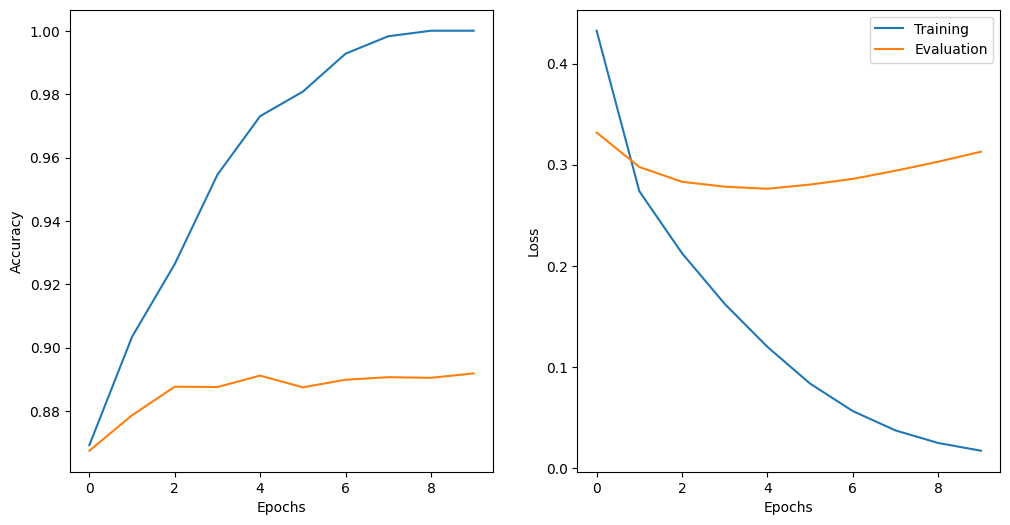

In [ ]:
def plot_result(num_epochs, train_accs, eval_accs, train_losses, eval_losses):
    epochs = list(range(num_epochs))
    fig, axs = plt.subplots(nrows = 1, ncols =2 , figsize = (12,6))
    axs[0].plot(epochs, train_accs, label = "Training")
    axs[0].plot(epochs, eval_accs, label = "Evaluation")
    axs[1].plot(epochs, train_losses, label = "Training")
    axs[1].plot(epochs, eval_losses, label = "Evaluation")
    axs[0].set_xlabel("Epochs")
    axs[1].set_xlabel("Epochs")
    axs[0].set_ylabel("Accuracy")
    axs[1].set_ylabel("Loss")
    plt.legend()

plot_result(num_epochs, train_accs, eval_accs, train_losses, eval_losses)

# V. Testing Trained Model

In [ ]:
test_dataset = encode_dataset(test_df)
test_dataset = to_map_style_dataset(test_dataset)

In [ ]:
test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_batch
)

In [ ]:
test_acc, test_loss = evaluate(model, criterion, test_dataloader, device)
test_acc, test_loss

(0.8966, 0.28708886628663993)

# VI. Inference

In [ ]:
tokenizer = get_tokenizer("basic_english")

def load_model(model_path, vocab_size=10000, embedding_dim=300, num_classes=2):
    model = TextCNN(
        vocab_size=vocab_size,
        embedding_dim=embedding_dim,
        kernel_sizes=[3, 4, 5],
        num_filters=100,
        num_classes=num_classes
    )
    model.load_state_dict(torch.load(model_path, weights_only=True))
    model.eval()
    return model

def inference(sentence, vocabulary, model):
    sentence = preprocess_text(sentence)
    encoded_sentence = vocabulary(tokenizer(sentence))
    encoded_sentence = torch.tensor(encoded_sentence)
    encoded_sentence = torch.unsqueeze(encoded_sentence, 1)

    with torch.no_grad():
        predictions = model(encoded_sentence)
    preds = nn.Softmax(dim=1)(predictions)
    p_max, yhat = torch.max(preds.data, 1)
    return round(p_max.item(), 2)*100, yhat.item()

In [ ]:
torch.save(model.state_dict(), save_model + '/text_cnn_model.pt')

In [ ]:
model = load_model('./model/text_cnn_model.pt')
inference(test_df['preprocess_sentence'][5999], vocabulary, model)

(57.99999999999999, 1)

In [ ]:
test_df

,sentence,label,preprocess_sentence
0,Hôm nào đi qua cũng thấy quán rất đông . Đi 2 ...,0,hôm nào đi qua cũng thấy quán rất đông đi ngườ...
1,"Vó bò ngon còn xách bò bình_thường , k đặc_sắc...",0,vó bò ngon còn xách bò bình thường k đặc sắc v...
2,"Trước giờ , cho_dù không thích nhân_viên , mìn...",0,trước giờ cho dù không thích nhân viên mình vẫ...
3,"Menu khá đa_dạng , phục_vụ nhanh .\n Quán có t...",0,menu khá đa dạng phục vụ nhanh quán có trà sữa...
4,Đọc review thấy vài bạn khen mà chẳng hiểu lý_...,0,đọc review thấy vài bạn khen mà chẳng hiểu lý ...
...,...,...,...
9995,"Không giân đạm chất âu , nhẹ_nhàng và rất sáng...",1,không giân đạm chất âu nhẹ nhàng và rất sáng t...
9996,Quán cafe take away gần nhà . Thỉnh_thoảng lườ...,1,quán cafe take away gần nhà thỉnh thoảng lười ...
9997,"Tân_Niên làm bữa hoành_tráng với gụ bò nướng ,...",1,tân niên làm bữa hoành tráng với gụ bò nướng ứ...
9998,"Quán ưa_thích , nhỏ bạn khoái cookie cream ở đ...",1,quán ưa thích nhỏ bạn khoái cookie cream ở đây...


In [ ]:
inference('Đồ ăn rất ngon và rẻ', vocabulary, model)

(75.0, 0)

In [ ]:
test_df['preprocess_sentence'][5999]

'nhân viên thân thiện dễ thương giá ổn và đặc biệt là vẽ đắp cái gì không được đều làm lại hết'